# Using a Custom Surface Brightness Profile from a FITS File

Isaac Cheng - April 2022

Here is a brief demonstration of how to use a custom surface brightness profile (i.e., an
image) with the `castor_etc` Python package.


In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

from castor_etc.background import Background
from castor_etc.photometry import Photometry
from castor_etc.sources import CustomSource
from castor_etc.telescope import Telescope


First, let's plot our data. (Note that the colour bar values are not real. They do not
represent the actual brightness of the Horsehead Nebula, in units of electron/s, as seen
by CASTOR).


In [2]:
import matplotlib as mpl
from astropy.io import fits
from astropy.wcs import WCS


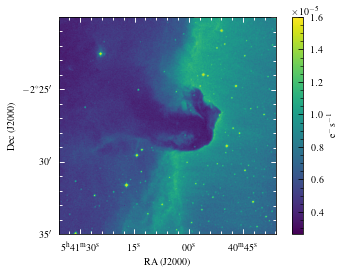

In [3]:
with mpl.rc_context(rc={"axes.grid": False}):
    data_original, header_original = fits.getdata(
        "./data/horsehead_profile.fits", header=True
    )
    fig, ax = plt.subplots(subplot_kw={"projection": WCS(header_original)})
    img_original = ax.imshow(data_original)
    cbar = fig.colorbar(img_original)
    cbar.set_label(r"e$^{-}$s$^{-1}$")
    cbar.ax.yaxis.set_offset_position("left")
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")
    ax.tick_params(axis="x", color="w")
    ax.tick_params(axis="y", color="w")
    plt.show()


To use your own images with the CASTOR exposure time calculator (ETC), simply use the
`CustomSource` class when defining your source. Your image should give the electrons
produced per second by the source in a specific passband.

This feature allows the user to bypass the ETC's built-in source generation machinery
(e.g., surface brightness profiles, source spectra, normalizations, etc.) while using the
most of the ETC's other functionality like sky background estimation and aperture
generation. The data will automatically be interpolated to the Telescope's resolution.


The `CustomSource` class has two required parameters:

1. the filepath to the FITS file containing your image. Again, the data should be in
   units of electron/s (though there is no specific check to enforce this requirement),
2. the telescope passband in which this image was taken or generated.

Recall that you can specify arbitrary passbands, passband response curves, etc. in your
`Telescope` instance. Photometric zero-points and pivot wavelengths will automatically be
calculated (assuming you do not provide them). See the `Telescope` class documentation for
the full list of configurable parameters.


In addition to the two required parameters, `CustomSource` also accepts an arbitrary
`center`. The `center` parameter should specify the centre of the source, which by default
is just the centre of the image. `center` can be a 2-tuple (x, y) in pixel coordinates or
any
[`astropy.coordinates.SkyCoord`](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord)
(we will show an example using a `SkyCoord` object below. [This
link](https://docs.astropy.org/en/stable/coordinates/index.html) also contains some
`SkyCoord` examples).

Finally, even if you are not using any `SkyCoord` objects, you should always check to make
sure that the pixel scale unit used to perform coordinate transformations (specified by
the `px_scale_unit` parameter in `CustomSource`) corresponds to the one given in the FITS
header (i.e., the "`CUNIT`" or "`CUNIT1`"/"`CUNIT2`" header keywords). This is because the
class converts all angular quantities to arcseconds internally. By default,
`px_scale_unit` is in degrees.

As always, we recommend that user read the relevant docstring(s) prior to using any ETC
functionality.


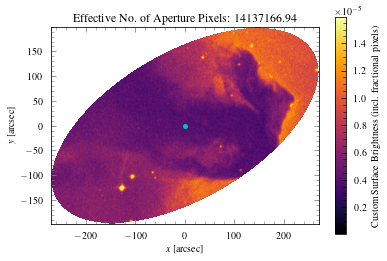

In [4]:
#
# Specify telescope parameters
#
MyTelescope = Telescope()
#
# Characterize sky background
#
MyBackground = Background()
MyBackground.add_geocoronal_emission("high")
#
# Use our own image for photometry
#
MySource = CustomSource("./data/horsehead_profile.fits", passband="g", center=None)
#
# Use a very large elliptical aperture. This may take a few seconds since it is a large
# interpolation
#
MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=300 * u.arcsec, b=150 * u.arcsec, center=[0, 0] << u.arcsec, rotation=30
)
# View the source rendered through the aperture
fig, ax, cbar = MyPhot.show_source_weights(mark_source=True, plot=False)
cbar.ax.yaxis.set_offset_position("left")
plt.show()


We can also specify another centre for our source.


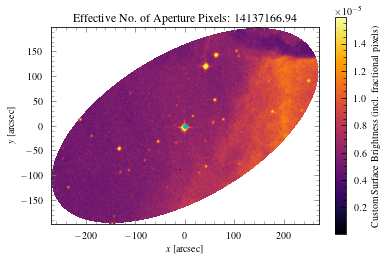

In [5]:
#
# Specify a different centre for the source
#
center = SkyCoord("5h41m17.25s", "-2d31m34s", frame="icrs")
MySource = CustomSource("./data/horsehead_profile.fits", passband="g", center=center)
#
# Render this new source through the same aperture
#
MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=300 * u.arcsec, b=150 * u.arcsec, center=[0, 0] << u.arcsec, rotation=30
)
# View the source rendered through the aperture
fig, ax, cbar = MyPhot.show_source_weights(mark_source=True, plot=False)
cbar.ax.yaxis.set_offset_position("left")
plt.show()


Finally, let's find the integration time (in seconds) required to achieve a
signal-to-noise ratio of 10. Notice that we only give results in the passband for which
the `CustomSource` is defined.

As the info message states, the reddening parameter is ignored for `CustomSource` objects.
This is because the `CustomSource` object's data should already be in units of electron/s
and thus bypasses internal ETC source brightness calculations.


In [6]:
MyPhot.calc_snr_or_t(snr=10)


INFO: The `reddening` parameter is ignored for `CustomSource` objects. You can silence this message by setting `quiet=True`.


{'g': 12614.911390528352}

Here is one more example using a brighter, exponentially-decaying elliptical profile and a
much smaller aperture.


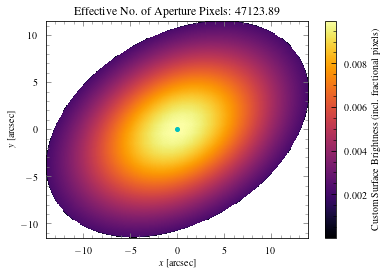

INFO: The `reddening` parameter is ignored for `CustomSource` objects. You can silence this message by setting `quiet=True`.


{'uv': 38.59140602476663}

In [7]:
#
# Specify telescope parameters
#
MyTelescope = Telescope()
#
# Characterize sky background
#
MyBackground = Background()
MyBackground.add_geocoronal_emission("high")
#
# Use our own image for photometry
#
MySource = CustomSource("./data/elliptical_profile.fits", passband="uv", center=None)
#
# Use an elliptical aperture
#
MyPhot = Photometry(MyTelescope, MySource, MyBackground)
MyPhot.use_elliptical_aperture(
    a=15 * u.arcsec, b=10 * u.arcsec, center=[0, 0] << u.arcsec, rotation=30
)
# View the source rendered through the aperture
fig, ax, cbar = MyPhot.show_source_weights(mark_source=True, plot=False)
cbar.ax.yaxis.set_offset_position("left")
plt.show()
#
# Calculate time (s) required to reach S/N = 20
#
MyPhot.calc_snr_or_t(snr=20)
